# Homework 5 - USA Airport Flight Analysis

In [3]:
import pandas as pd
from typing import Dict, Any, List, Tuple, Set
from collections import defaultdict
import dash
from dash import dcc, html, dash_table
import seaborn as sns
import matplotlib.pyplot as plt
import io
import base64
import numpy as np



## EDA

In [4]:

file_path = 'archive_usa_airport/Airports2.csv'
df = pd.read_csv(file_path)
df.isna().sum()

Origin_airport               0
Destination_airport          0
Origin_city                  0
Destination_city             0
Passengers                   0
Seats                        0
Flights                      0
Distance                     0
Fly_date                     0
Origin_population            0
Destination_population       0
Org_airport_lat           6954
Org_airport_long          6954
Dest_airport_lat          6807
Dest_airport_long         6807
dtype: int64

In [5]:

def find_missing_coordinates(df: pd.DataFrame) -> Tuple[Set[Tuple[str, str]], int]:
    """
    Find the airports with missing data.
    """
    missing_org = df[(df['Org_airport_lat'].isna() & df['Org_airport_long'].isna())]
    missing_dest = df[(df['Dest_airport_lat'].isna() & df['Dest_airport_long'].isna())]

    unique_origin = set(zip(missing_org['Origin_airport'], missing_org['Origin_city']))
    unique_dest = set(zip(missing_dest['Destination_airport'], missing_dest['Destination_city']))

    unique_airports = unique_origin.union(unique_dest)
    return unique_airports, len(unique_airports)
unique_airports, missing_count = find_missing_coordinates(df)
print(f"Numero di aeroporti con coordinate mancanti: {missing_count}")




Numero di aeroporti con coordinate mancanti: 243


In [6]:
def export_missing_airports(airports: Set[Tuple[str, str]], output_file: str) -> None:
    """
    Export the missing airports to a CSV file. In order to fetch coordinates through API
    """
    df_missing = pd.DataFrame(list(airports), columns=['Airport Code', 'City'])
    df_missing.to_csv(output_file, index=False, sep=';')

export_missing_airports(unique_airports, 'archive_usa_airport/airports_without_coordinates.csv')



In [7]:

coordinates_file = 'archive_usa_airport/airport_coordinates_.csv'
coordinates_df = pd.read_csv(coordinates_file, sep=';')

def create_airport_mapping(coordinates_df: pd.DataFrame) -> Dict:
    """
    A mapping of airport codes to their corresponding coordinates.
    """
    return coordinates_df.set_index('airport_code')[['latitude', 'longitude']].to_dict(orient='index')

airport_mapping = create_airport_mapping(coordinates_df)

def fill_missing_coordinates(df: pd.DataFrame, airport_mapping: Dict) -> pd.DataFrame:


    df['Org_airport_lat'] = df['Org_airport_lat'].fillna(
        df['Origin_airport'].map(lambda x: airport_mapping.get(x, {}).get('latitude'))
    )
    df['Org_airport_long'] = df['Org_airport_long'].fillna(
        df['Origin_airport'].map(lambda x: airport_mapping.get(x, {}).get('longitude'))
    )

    df['Dest_airport_lat'] = df['Dest_airport_lat'].fillna(
        df['Destination_airport'].map(lambda x: airport_mapping.get(x, {}).get('latitude'))
    )
    df['Dest_airport_long'] = df['Dest_airport_long'].fillna(
        df['Destination_airport'].map(lambda x: airport_mapping.get(x, {}).get('longitude'))
    )

    return df


df_final = fill_missing_coordinates(df, airport_mapping)
df_final.isna().sum()

Origin_airport            0
Destination_airport       0
Origin_city               0
Destination_city          0
Passengers                0
Seats                     0
Flights                   0
Distance                  0
Fly_date                  0
Origin_population         0
Destination_population    0
Org_airport_lat           0
Org_airport_long          0
Dest_airport_lat          0
Dest_airport_long         0
dtype: int64

## 1. Flight Network Analysis (Q1)

### 1.1 analyze_graph_feature

In [8]:
from auxiliary_files.flight_network import FlightNetwork
from auxiliary_files.GraphAnalysis import GraphAnalysis
from typing import Dict

def analyze_graph_features(network: FlightNetwork) -> Dict:
    """Analyze the flight network graph and return key metrics."""
    # Create an instance of GraphAnalysis
    graph_analysis = GraphAnalysis(network)

    # Get graph metrics
    n_nodes = network.graph.number_of_nodes()
    n_edges = network.graph.number_of_edges()
    density = graph_analysis.calculate_graph_density(n_nodes, n_edges)

    # Get degree metrics
    in_degrees, out_degrees = graph_analysis.get_degree_metrics()

    # Identify hubs and create hubs table
    hubs = graph_analysis.identify_hub_airports()
    hubs_table = graph_analysis.create_hubs_table(hubs, in_degrees, out_degrees)

    return {
        'n_airports': n_nodes,
        'n_flights': n_edges,
        'density': density,
        'in_degrees': in_degrees,
        'out_degrees': out_degrees,
        'hubs_table': hubs_table,
    }




## 1.2 summarize_graph_features

In [9]:

app = dash.Dash(__name__)

# Initialize FlightNetwork
flightnetwork = FlightNetwork()

# Create origin and destination series
origin_airports = df_final['Origin_airport']
destination_airports = df_final['Destination_airport']
# Add nodes and edges to the network
flightnetwork.add_nodes_and_edges(origin_airports, destination_airports)
graph_analysis = GraphAnalysis(flightnetwork)
# Define layout directly
app.layout = html.Div([
    html.H1("Flight Network Analysis"),
    html.Div(id="summary-text"),
    html.Div([
        html.Div([
            html.H3("In-degree Distribution"),
            html.Img(id="in-degree-plot", style={"width": "100%", "height": "auto"})
        ], style={"width": "48%", "display": "inline-block"}),
        html.Div([
            html.H3("Out-degree Distribution"),
            html.Img(id="out-degree-plot", style={"width": "100%", "height": "auto"})
        ], style={"width": "48%", "display": "inline-block"})
    ], style={"display": "flex", "justify-content": "space-between", "margin-top": "30px"}),
    html.Div([
        html.H3("Top Hubs (Airports with highest degree)"),
        dash_table.DataTable(
            id='hubs-table',
            columns=[{"name": col, "id": col} for col in ['Airport', 'In-degree', 'Out-degree', 'Total degree']],
            style_table={'height': '300px', 'overflowY': 'auto'}
        ),
    ], style={"margin-top": "40px"})
])

@app.callback(
    [
        dash.dependencies.Output("summary-text", "children"),
        dash.dependencies.Output("in-degree-plot", "src"),
        dash.dependencies.Output("out-degree-plot", "src"),
        dash.dependencies.Output("hubs-table", "data"),
    ],
    [dash.dependencies.Input("summary-text", "children")]
)
def summarize_graph_feature(_):
    
    results = analyze_graph_features(flightnetwork)
    
    summary_text = f"""
        Network Analysis Report:
        - Number of Airports (Nodes): {results['n_airports']}
        - Number of Flights (Edges): {results['n_flights']}
                - Graph Density: {results['density']:.4f}
    """
    
    in_degree_image = graph_analysis.get_image_from_figure(graph_analysis.plot_degree_distribution(list(results['in_degrees'].values()), "In-degree"))
    
    out_degree_image = graph_analysis.get_image_from_figure(graph_analysis.plot_degree_distribution(list(results['out_degrees'].values()), "Out-degree"))
    
    return summary_text.strip(), in_degree_image, out_degree_image, results['hubs_table'].to_dict('records')

if __name__ == "__main__":
    app.run_server(debug=True)


## 1.3

### Compute total passenger flow between origin and destination cities.

In [23]:

def compute_passenger_flow_cities(data):

    total_passenger_flow = data.groupby(['Origin_city', 'Destination_city'])['Passengers'].sum().reset_index()
    total_passenger_flow = total_passenger_flow.sort_values(by='Passengers', ascending=False)
    return total_passenger_flow

passenger_flow_cities = compute_passenger_flow_cities(df)
display(passenger_flow_cities)

,Origin_city,Destination_city,Passengers
7122,"Dallas, TX","Houston, TX",38295025
12391,"Houston, TX","Dallas, TX",37989016
13585,"Kahului, HI","Honolulu, HI",32364664
12259,"Honolulu, HI","Kahului, HI",29744742
16133,"Los Angeles, CA","Honolulu, HI",28964232
...,...,...,...
14206,"Klamath Falls, OR","Anchorage, AK",0
14218,"Klamath Falls, OR","Roseburg, OR",0
25915,"Seattle, WA","West Palm Beach, FL",0
14226,"Knoxville, TN","Albany, GA",0


### Identify and visualize the busiest routes by passenger traffic.

In [11]:
top_flights = (
    df.groupby(['Origin_airport', 'Destination_airport', 'Org_airport_lat', 'Org_airport_long', 'Dest_airport_lat', 'Dest_airport_long'])
    .agg({'Passengers': 'sum', 'Flights': 'sum', 'Seats': 'sum'})  # Sommare passeggeri, voli, posti a sedere
    .reset_index()
    .sort_values(by='Passengers', ascending=False)
)

In [12]:
def compute_passenger_flow_airports(df):

    return top_flights

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator, FuncFormatter
import numpy as np

def plot_busiest_routes_airports(passenger_flow):
    
    passenger_flow['Route'] = passenger_flow['Origin_airport'] + " - " + passenger_flow['Destination_airport']

    # Ordina per numero di passeggeri in ordine decrescente e seleziona le prime 45 rotte più trafficate
    top_routes = passenger_flow.sort_values(by='Passengers', ascending=False).head(45)

    # Crea il grafico a barre orizzontali
    plt.figure(figsize=(12, 8))

    # Mapping passengers to color scale
    norm = plt.Normalize(top_routes['Passengers'].min(), top_routes['Passengers'].max())
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])

    # Seaborn barplot with custom colors based on passenger count
    sns.barplot(x='Passengers', y='Route', data=top_routes, palette="viridis", errorbar=None)


    # Personalizza il grafico
    plt.title('Busiest Routes by Passenger Traffic (Airports)', fontsize=14)
    plt.xlabel('Total Passengers', fontsize=12)
    plt.ylabel('Routes (Origin - Destination)', fontsize=12)
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))  
    

    # Rimuove la legenda
    plt.legend([], frameon=False)

    # Ottimizza la disposizione
    plt.tight_layout()

    # Mostra il grafico
    plt.show()

,Origin_airport,Destination_airport,Passengers
25706,OGG,HNL,32364612
15625,HNL,OGG,29744742
19159,LAX,HNL,28964154
15606,HNL,LAX,28632161
18874,LAS,LAX,26333721
...,...,...,...
19487,LBL,PIA,0
19489,LBL,RFD,0
19491,LBL,SDM,0
19496,LBL,YIP,0


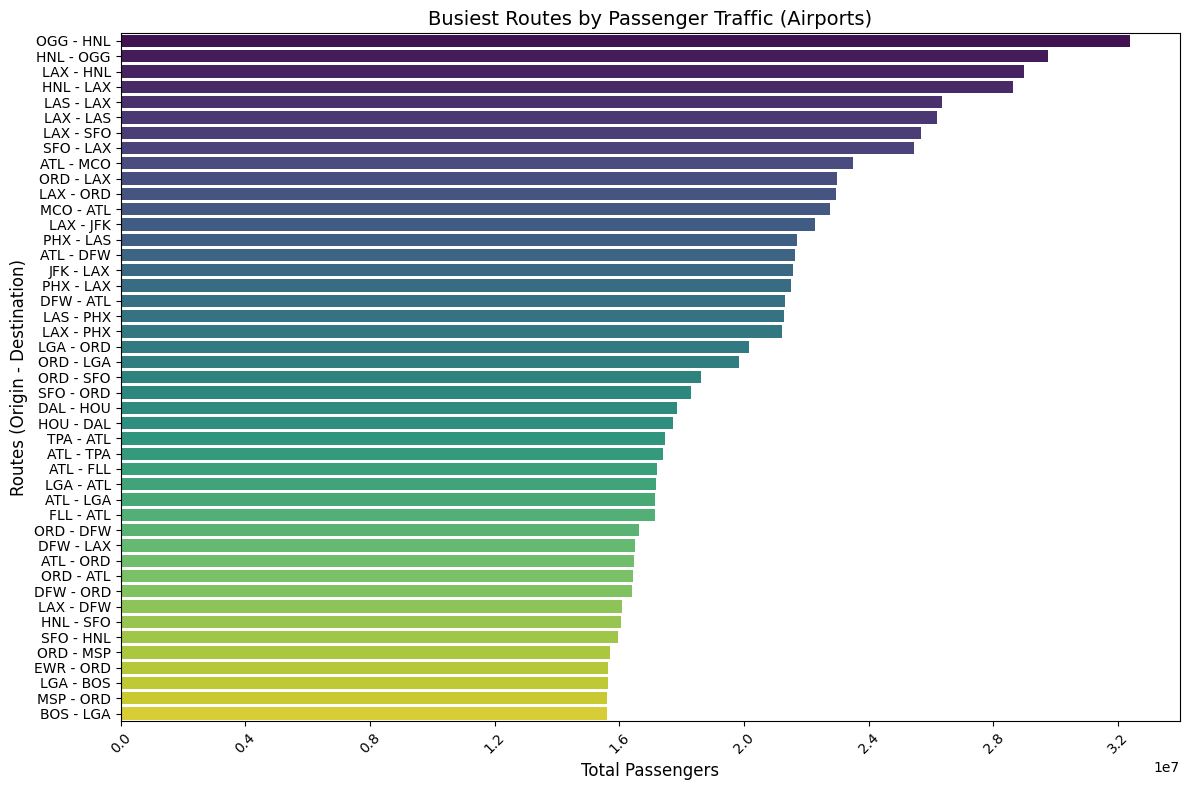

In [14]:

passenger_flow_airports = compute_passenger_flow_airports(df)

display(passenger_flow_airports[['Origin_airport', 'Destination_airport', 'Passengers']])

plot_busiest_routes_airports(passenger_flow_airports)

### Calculate the average passengers per flight for each route and highlight under/over-utilized connections.

In [15]:

def calculate_efficiency(df):
    top_flights['Efficiency'] = top_flights['Passengers'] / top_flights['Seats']
    top_flights['Passengers_per_Flight'] = top_flights['Passengers'] / top_flights['Flights']
    top_flights_sorted = top_flights.sort_values(by=['Efficiency', 'Passengers'], ascending=[False, False])

    top_flights_sorted['Route'] = top_flights_sorted['Origin_airport'] + " - " + top_flights_sorted['Destination_airport']
    
    
    return top_flights_sorted

In [16]:
def display_top_routes(top_routes_sorted):
    
    display(top_routes_sorted[['Origin_airport', 'Destination_airport', 'Passengers', 'Efficiency', 'Route']])
    

In [17]:

def plot_efficiency_barplot(top_routes_sorted):
    """Visualizza il grafico a barre basato sull'efficienza delle rotte."""
    
    top_routes_45 = top_routes_sorted.head(45)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Efficiency', y='Route', data=top_routes_45, palette="viridis")

    
    plt.title('Top 45 Busiest Routes by Efficiency (Passenger to Seat Ratio)', fontsize=14)
    plt.xlabel('Efficiency (Passengers / Seats)', fontsize=12)
    plt.ylabel('Routes (Origin - Destination)', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

,Origin_airport,Destination_airport,Passengers,Efficiency,Route
29361,RDU,PKB,60,1.016949,RDU - PKB
16337,IAD,MCW,486,1.000000,IAD - MCW
21891,MCW,IAD,486,1.000000,MCW - IAD
33734,STL,MWH,380,1.000000,STL - MWH
33018,SLN,DQF,349,1.000000,SLN - DQF
...,...,...,...,...,...
19487,LBL,PIA,0,NaN,LBL - PIA
19489,LBL,RFD,0,NaN,LBL - RFD
19491,LBL,SDM,0,NaN,LBL - SDM
19496,LBL,YIP,0,NaN,LBL - YIP


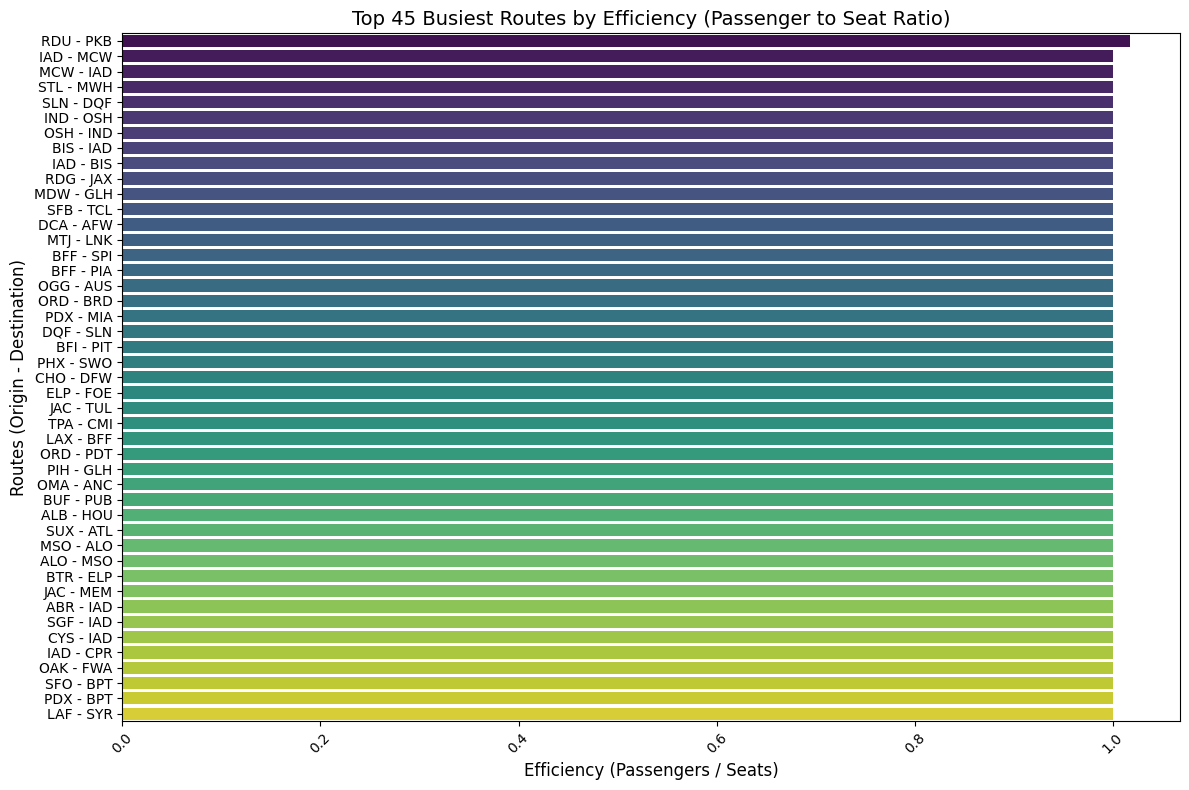

In [18]:

top_routes_sorted = calculate_efficiency(df)

display_top_routes(top_routes_sorted)

plot_efficiency_barplot(top_routes_sorted)

In [19]:
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns

def plot_top_flights(df, top_n=30):
    
    
    top_flights = (
        df.groupby(['Origin_airport', 'Destination_airport', 'Org_airport_lat', 'Org_airport_long',
                    'Dest_airport_lat', 'Dest_airport_long'])
        .agg({'Passengers': 'sum', 'Flights': 'sum', 'Seats': 'sum'})
        .reset_index()
        .sort_values(by='Passengers', ascending=False)
    )

    
    top_flights['Passengers_per_Flight'] = top_flights['Passengers'] / top_flights['Flights']
    top_flights['Seat_Efficiency'] = top_flights['Passengers'] / top_flights['Seats']

    # Funzione per rimuovere duplicati bidirezionali
    def remove_bidirectional_duplicates(data):
        seen = set()
        unique_routes = []
        for _, row in data.iterrows():
            route = tuple(sorted([row['Origin_airport'], row['Destination_airport']]))
            if route not in seen:
                seen.add(route)
                unique_routes.append(row)
        return pd.DataFrame(unique_routes)

    
    top_flights = remove_bidirectional_duplicates(top_flights.head(top_n))

    
    palette = sns.color_palette("husl", 8)

    
    fig = go.Figure()

    # Aggiungere i marker degli aeroporti di origine
    fig.add_trace(
        go.Scattergeo(
            lon=top_flights['Org_airport_long'],
            lat=top_flights['Org_airport_lat'],
            text=top_flights.apply(
                lambda row: f"{row['Origin_airport']}<br>{row['Passengers_per_Flight']:.1f} Passengers per Flight<br>Seat Efficiency: {row['Seat_Efficiency']:.2f}", axis=1
            ),
            mode='markers',
            marker=dict(
                size=top_flights['Passengers_per_Flight'],
                color='blue',
                sizeref=max(top_flights['Passengers_per_Flight']) / 30,
                sizemode='diameter'
            ),
            name='Origin Airports'
        )
    )

    # Aggiungere i marker degli aeroporti di destinazione
    fig.add_trace(
        go.Scattergeo(
            lon=top_flights['Dest_airport_long'],
            lat=top_flights['Dest_airport_lat'],
            text=top_flights.apply(
                lambda row: f"{row['Destination_airport']}<br>{row['Passengers_per_Flight']:.1f} Passengers per Flight<br>Seat Efficiency: {row['Seat_Efficiency']:.2f}", axis=1
            ),
            mode='markers',
            marker=dict(
                size=top_flights['Passengers_per_Flight'],
                color='red',
                sizeref=max(top_flights['Passengers_per_Flight']) / 30,
                sizemode='diameter'
            ),
            name='Destination Airports'
        )
    )

    # Aggiungere le linee dei voli
    for idx, row in top_flights.iterrows():
        color = f'rgb({int(palette[idx % 8][0] * 255)}, {int(palette[idx % 8][1] * 255)}, {int(palette[idx % 8][2] * 255)})'

        fig.add_trace(
            go.Scattergeo(
                lon=[row['Org_airport_long'], row['Dest_airport_long']],
                lat=[row['Org_airport_lat'], row['Dest_airport_lat']],
                mode='lines',
                line=dict(width=2, color=color),
                opacity=0.7,
                name=f"{row['Origin_airport']} to {row['Destination_airport']}"
            )
        )

    # Configurare il layout della mappa
    fig.update_layout(
        title_text=f'Top {top_n} Flights (Passengers per Flight and Seat Efficiency)',
        showlegend=True,
        geo=dict(
            scope='usa',
            showland=True,
            landcolor='rgb(217, 217, 217)',
            projection_type='albers usa',
            coastlinecolor="Black",
            showcoastlines=True
        )
    )

    return fig

def plot_bottom_flights(df, bottom_n=15):
    """
    Plot an interactive map of the bottom N flights based on total passengers.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing flight data with columns:
                          ['Origin_airport', 'Destination_airport', 'Org_airport_lat', 'Org_airport_long',
                           'Dest_airport_lat', 'Dest_airport_long', 'Passengers']
        bottom_n (int): Number of bottom flights to display based on total passengers.

    Returns:
        fig (go.Figure): The plotly figure object.
    """
    # Aggregare i dati
    bottom_flights = (
        df.groupby(['Origin_airport', 'Destination_airport', 'Org_airport_lat', 'Org_airport_long',
                    'Dest_airport_lat', 'Dest_airport_long'])
        .agg({'Passengers': 'sum'})
        .reset_index()
        .sort_values(by='Passengers', ascending=True)
    )

    # Funzione per rimuovere duplicati bidirezionali
    def remove_bidirectional_duplicates(data):
        seen = set()
        unique_routes = []
        for _, row in data.iterrows():
            route = tuple(sorted([row['Origin_airport'], row['Destination_airport']]))
            if route not in seen:
                seen.add(route)
                unique_routes.append(row)
        return pd.DataFrame(unique_routes)

    # Applicare il filtro per i bottom N voli
    bottom_flights = remove_bidirectional_duplicates(bottom_flights.head(bottom_n))

    # Palette per le linee
    palette = sns.color_palette("hls", 8)

    # Creare la mappa interattiva
    fig = go.Figure()

    # Aggiungere i marker degli aeroporti di origine
    fig.add_trace(
        go.Scattergeo(
            lon=bottom_flights['Org_airport_long'],
            lat=bottom_flights['Org_airport_lat'],
            text=bottom_flights.apply(
                lambda row: f"{row['Origin_airport']}<br>{row['Passengers'] / 1e6:.1f} million Passengers", axis=1
            ),
            mode='markers',
            marker=dict(size=10, color='blue'),
            name='Origin Airports'
        )
    )

    # Aggiungere i marker degli aeroporti di destinazione
    fig.add_trace(
        go.Scattergeo(
            lon=bottom_flights['Dest_airport_long'],
            lat=bottom_flights['Dest_airport_lat'],
            text=bottom_flights.apply(
                lambda row: f"{row['Destination_airport']}<br>{row['Passengers'] / 1e6:.1f} million Passengers", axis=1
            ),
            mode='markers',
            marker=dict(size=10, color='red'),
            name='Destination Airports'
        )
    )

    # Aggiungere le linee dei voli
    for idx, row in bottom_flights.iterrows():
        color = f'rgb({int(palette[idx % 8][0] * 255)}, {int(palette[idx % 8][1] * 255)}, {int(palette[idx % 8][2] * 255)})'

        fig.add_trace(
            go.Scattergeo(
                lon=[row['Org_airport_long'], row['Dest_airport_long']],
                lat=[row['Org_airport_lat'], row['Dest_airport_lat']],
                mode='lines',
                line=dict(width=2, color=color),
                opacity=0.7,
                name=f"{row['Origin_airport']} to {row['Destination_airport']}"
            )
        )

    # Configurare il layout della mappa
    fig.update_layout(
        title_text=f'Bottom {bottom_n} Flights (In Terms of Passengers)',
        showlegend=True,
        geo=dict(
            scope='usa',
            showland=True,
            landcolor='rgb(217, 217, 217)',
            projection_type='albers usa',
            coastlinecolor="Black",
            showcoastlines=True
        )
    )

    return fig




In [20]:
top_fig = plot_top_flights(df, top_n=30)
bottom_fig = plot_bottom_flights(df, bottom_n=30)

# Mostrare le mappe affiancate
top_fig.show()
bottom_fig.show()

In [21]:
# Initialize the flight network
flight_network = FlightNetwork()
flight_network.add_nodes_and_edges(df['Origin_airport'], df['Destination_airport'])


In [22]:
### manca mappa